In [1]:
import sys
import platform
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# ---- repo setup (so `src/` imports work from anywhere) ----
repo_root = Path.cwd().resolve()
for _ in range(10):
    if (repo_root / 'src').exists() and (repo_root / 'paper2').exists():
        break
    repo_root = repo_root.parent
src_path = str(repo_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print('Python:', sys.version.split()[0])
print('Platform:', platform.platform())
print('Repo root:', repo_root)

Python: 3.13.5
Platform: Windows-11-10.0.26200-SP0
Repo root: C:\workspace\Physics\X-theta-framework


R, area, Δθ_hol:
 0.250    0.196350     -0.392699
 0.500    0.785398     -1.570796
 1.000    3.141593     -6.283183
 1.500    7.068583    -14.137161
max |error|: 5.816584087270371e-06


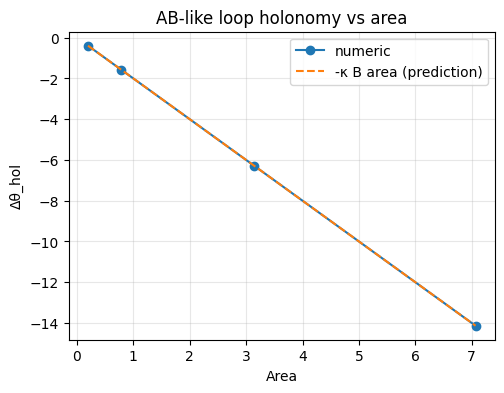

In [2]:
def A_symmetric_gauge(xy: np.ndarray, B: float) -> np.ndarray:
    """2D symmetric-gauge potential: A = (B/2) (-y, x)."""
    x = xy[..., 0]
    y = xy[..., 1]
    return np.stack([-(B / 2.0) * y, (B / 2.0) * x], axis=-1)

def loop_circle(R: float, n: int = 2000) -> np.ndarray:
    t = np.linspace(0.0, 2.0 * np.pi, n, endpoint=True)
    return np.stack([R * np.cos(t), R * np.sin(t)], axis=-1)

def line_integral_A_dot_dx(points: np.ndarray, B: float) -> float:
    # Discrete line integral: sum A(x_i) · (x_{i+1}-x_i)
    pts = np.asarray(points)
    dpts = np.diff(pts, axis=0)
    A = A_symmetric_gauge(pts[:-1], B)
    return float(np.sum(np.einsum('ij,ij->i', A, dpts)))

def holonomy(points: np.ndarray, kappa: float, B: float) -> float:
    return -kappa * line_integral_A_dot_dx(points, B)

# Demo parameters
kappa = 1.0
B = 2.0
Rs = [0.25, 0.5, 1.0, 1.5]

rows = []
for R in Rs:
    pts = loop_circle(R, n=4000)
    dth = holonomy(pts, kappa=kappa, B=B)
    area = np.pi * R * R
    rows.append((R, area, dth))

rows = np.array(rows)
print('R, area, Δθ_hol:')
for R, area, dth in rows:
    print(f'{R:>6.3f}  {area:>10.6f}  {dth:>12.6f}')

# In this gauge: ∮ A·dx = B * area, so Δθ_hol = -kappa * B * area
pred = -kappa * B * rows[:, 1]
err = rows[:, 2] - pred
print('max |error|:', float(np.max(np.abs(err))))

plt.figure(figsize=(5.5, 4))
plt.plot(rows[:, 1], rows[:, 2], 'o-', label='numeric')
plt.plot(rows[:, 1], pred, '--', label='-κ B area (prediction)')
plt.xlabel('Area')
plt.ylabel('Δθ_hol')
plt.title('AB-like loop holonomy vs area')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()